# Homework: Cycle Generative Adversarial Network (CycleGAN)

In [1]:
# Load the necessary imports
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from library import datasets, models
from flax import linen as nn
from jax import random, numpy as jnp
import optax
import pandas as pd
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objects as go
pio.renderers.default = 'notebook_connected'

## Dataset

In [2]:
# Load dataset
key = random.PRNGKey(5)
key_A, key_B = random.split(key)

A = datasets.utils.make_blobs(n_samples=1000, min_sigma=0, max_sigma=0.1, key=key_A)
B = datasets.utils.make_blobs(n_samples=1000, min_sigma=0, max_sigma=0.1, key=key_B)

real_A = A.get_tensors()
real_B = B.get_tensors()

In [3]:
fig = make_subplots(rows=1, cols=2, subplot_titles=["Distribution A", "Distribution B"])

fig.add_trace(
    go.Scatter(x=real_A[:, 0], y=real_A[:, 1], mode='markers', marker=dict(color="blue"),name='Real A'),#, color=jnp.ones(len(real_A)), range_color=(0,1)),
    row=1, col=1)

fig.add_trace(
    go.Scatter(x=real_B[:, 0], y=real_B[:, 1], mode='markers', marker=dict(color="green"), name='Real B'),#, color=jnp.ones(len(real_B)), range_color=(0,1)),
    row=1, col=2)

fig.update_layout(title_text="Real samples")
fig.show()

## Part (A): Define discriminator and generator

In [4]:
# Define ambient dimension, discriminator and generator
AMBIENT_DIM = 2

discriminator_A = nn.Sequential([
    nn.Dense(8),
    nn.relu,
    nn.Dense(16),
    nn.relu,
    nn.Dense(16),
    nn.relu,
    nn.Dense(8),
    nn.relu,
    nn.Dense(1), # TODO: Complete output dimension
])

discriminator_B = nn.Sequential([
    nn.Dense(8),
    nn.relu,
    nn.Dense(16),
    nn.relu,
    nn.Dense(16),
    nn.relu,
    nn.Dense(8),
    nn.relu,
    nn.Dense(1), # TODO: Complete output dimension
])

generator_AB = nn.Sequential([
    nn.Dense(8),
    nn.relu,
    nn.Dense(8),
    nn.relu,
    nn.Dense(4),
    nn.relu,
    nn.Dense(AMBIENT_DIM), # TODO: Complete output dimension
])

generator_BA = nn.Sequential([
    nn.Dense(8),
    nn.relu,
    nn.Dense(8),
    nn.relu,
    nn.Dense(4),
    nn.relu,
    nn.Dense(AMBIENT_DIM), # TODO: Complete output dimension
])


In [5]:
model = models.cyclegan.CycleGAN(
    {
        'generator_AB': generator_AB,
        'generator_BA': generator_BA,
        'discriminator_A': discriminator_A,
        'discriminator_B': discriminator_B,
    },
    (AMBIENT_DIM,), (AMBIENT_DIM,))

model.initialize(optax.sigmoid_binary_cross_entropy)

In [6]:
gan_AB, gan_BA = model.create_distribution()
fake_A = gan_BA.draw_samples(real_B)
fake_B = gan_AB.draw_samples(real_A)


In [7]:
fig = make_subplots(rows=1, cols=2, subplot_titles = ["Distribution A", "Distribution B"])

fig.add_trace(
    go.Scatter(x=real_A[:, 0], y=real_A[:, 1], mode='markers', marker=dict(color="blue"),name='Real A'),
    row=1, col=1)

fig.add_trace(
    go.Scatter(x=real_B[:, 0], y=real_B[:, 1], mode='markers', marker=dict(color="green"),name='Real B'),
    row=1, col=2)

fig.add_trace(
    go.Scatter(x=fake_A[:, 0], y=fake_A[:, 1], mode='markers', marker=dict(color="red"),name='Fake'),
    row=1, col=1)

fig.add_trace(
    go.Scatter(x=fake_B[:, 0], y=fake_B[:, 1], mode='markers', marker=dict(color="red"),name='Fake', showlegend=False),
    row=1, col=2)


fig.update_layout(title_text="Real samples and fake samples from untrained generators")
fig.show()

## Part (B-D): Implement cycle consistency loss and train CycleGAN

Complete the blank parts in the train method in `cyclegan.py` and train the CycleGAN model below.

In [8]:
# Code cell with training loop. Complete blank parts
history = model.train(A, B, optax.adam(learning_rate=5e-3), print_every=5, batch_size=1000, num_epochs=500, cycle_loss_weight=5)

epoch 0; g_AB_l_g:  6.99e-01 g_AB_l_c:  8.26e-01; g_BA_l_g:  7.24e-01 g_BA_l_c:  7.57e-01; d_A_l:  6.78e-01; d_B_l:  7.20e-01; g_AB_gm:  9.46e-02; g_BA_gm:  5.48e-02; dis_A_gm:  6.76e-03; dis_B_gm:  1.81e-02: : 1it [00:06,  6.19s/it]
epoch 1; g_AB_l_g:  6.94e-01 g_AB_l_c:  8.23e-01; g_BA_l_g:  7.38e-01 g_BA_l_c:  7.07e-01; d_A_l:  6.69e-01; d_B_l:  7.12e-01; g_AB_gm:  9.87e-02; g_BA_gm:  6.22e-02; dis_A_gm:  8.37e-03; dis_B_gm:  1.07e-02: : 1it [00:00,  2.24it/s]
epoch 2; g_AB_l_g:  6.90e-01 g_AB_l_c:  8.19e-01; g_BA_l_g:  7.55e-01 g_BA_l_c:  6.52e-01; d_A_l:  6.59e-01; d_B_l:  7.08e-01; g_AB_gm:  1.04e-01; g_BA_gm:  6.95e-02; dis_A_gm:  8.86e-03; dis_B_gm:  9.73e-03: : 1it [00:00,  2.26it/s]
epoch 3; g_AB_l_g:  6.88e-01 g_AB_l_c:  8.19e-01; g_BA_l_g:  7.76e-01 g_BA_l_c:  5.91e-01; d_A_l:  6.47e-01; d_B_l:  7.04e-01; g_AB_gm:  1.05e-01; g_BA_gm:  7.58e-02; dis_A_gm:  1.03e-02; dis_B_gm:  8.68e-03: : 1it [00:00,  1.94it/s]
epoch 4; g_AB_l_g:  6.87e-01 g_AB_l_c:  8.15e-01; g_BA_l_g:  8.0

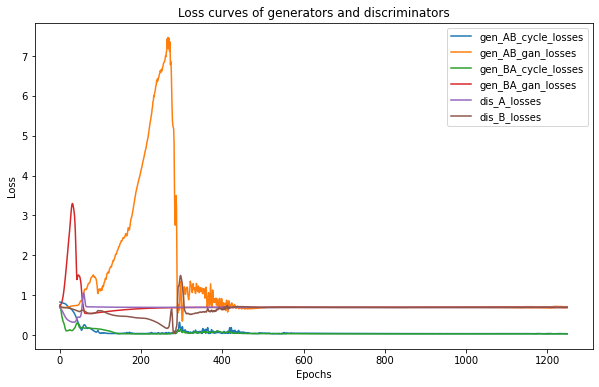

In [13]:
fig = plt.figure(figsize=(10, 6))
for key, value in history.items():
    plt.plot(range(len(value)), value, label=key)
plt.legend()
plt.title("Loss curves of generators and discriminators")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [10]:
gan_AB, gan_BA = model.create_distribution()
fake_A = gan_BA.draw_samples(real_B)
fake_B = gan_AB.draw_samples(real_A)

In [14]:
fig = make_subplots(rows=1, cols=2, subplot_titles = ["Distribution A", "Distribution B"])

fig.add_trace(
    go.Scatter(x=real_A[:, 0], y=real_A[:, 1], mode='markers', marker=dict(color="blue"),name='Real A'),
    row=1, col=1)

fig.add_trace(
    go.Scatter(x=real_B[:, 0], y=real_B[:, 1], mode='markers', marker=dict(color="green"),name='Real B'),
    row=1, col=2)

fig.add_trace(
    go.Scatter(x=fake_A[:, 0], y=fake_A[:, 1], mode='markers', marker=dict(color="red"),name='Fake'),
    row=1, col=1)

fig.add_trace(
    go.Scatter(x=fake_B[:, 0], y=fake_B[:, 1], mode='markers', marker=dict(color="red"),name='Fake', showlegend=False),
    row=1, col=2)


fig.update_layout(title_text="Real samples and fake samples from trained generators")
fig.show()